# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name:** Parsa Alizadeh
- **Student ID:** 810101572

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'AIS25-CA4')
os.chdir(GOOGLE_DRIVE_PATH)

ModuleNotFoundError: No module named 'google'

## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device



'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [ ]:
# inverse the normilize transform to restore the original data
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        # YOUR CODE HERE
        _mean = self.mean.to(tensor.device).view(-1, 1, 1)
        _std = self.std.to(tensor.device).view(-1, 1, 1)
        tensor = tensor.mul(_std).add_(_mean)
        if gray:
            tensor = torch.sum(tensor * torch.tensor(coeff).view(-1, 1, 1).to(tensor.device), dim=0, keepdim=True)
        return tensor


norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

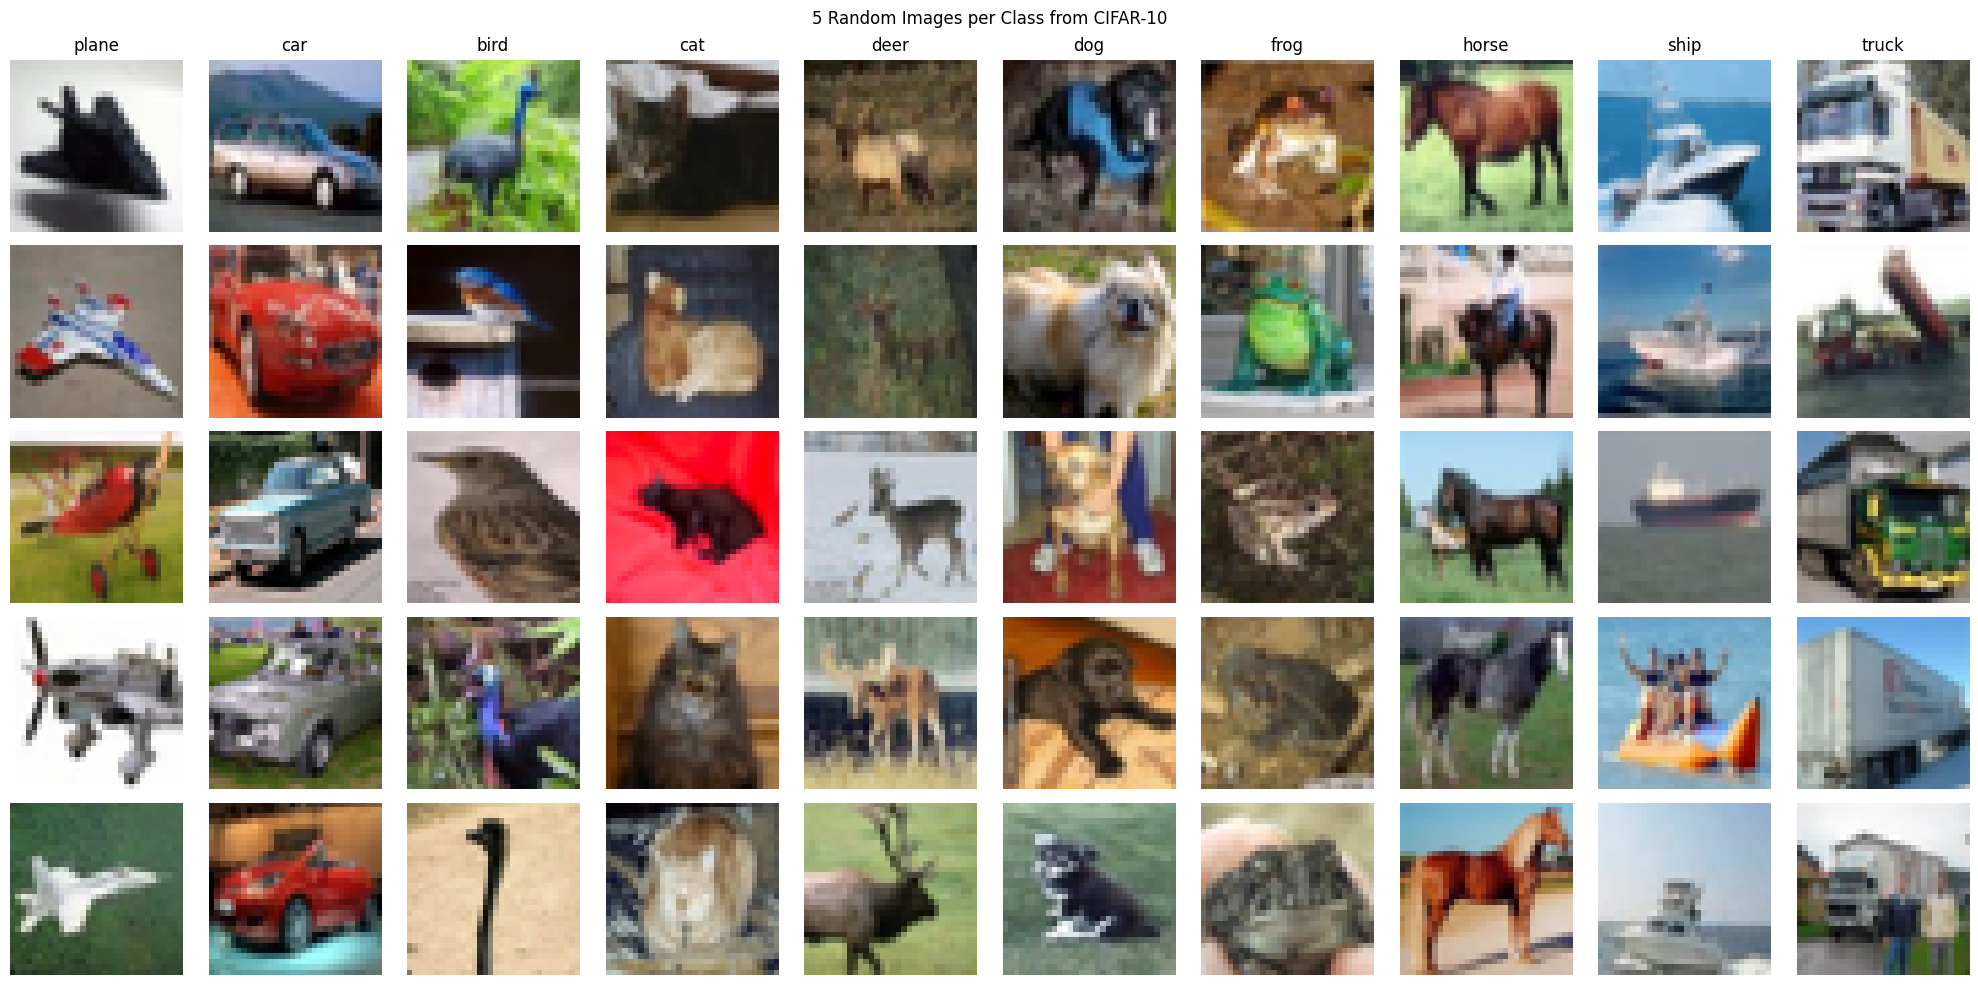

In [ ]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np

# Collect 5 images per class
images_per_class = {i: [] for i in range(10)}
for img, label in initial_trainset:
    if len(images_per_class[label]) < 5:
        images_per_class[label].append(img)
    if all(len(images_per_class[i]) == 5 for i in range(10)):
        break

# Visualize
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
fig.suptitle('5 Random Images per Class from CIFAR-10')
for col, class_idx in enumerate(range(10)):
    for row in range(5):
        img = norminv(images_per_class[class_idx][row])
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
        if row == 0:
            axs[row, col].set_title(classes[class_idx])
plt.tight_layout()
plt.show()


# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [ ]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import math
from torchvision import transforms

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(FullyConnectedNetwork, self).__init__()
        # YOUR CODE HERE
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 4100),
            nn.BatchNorm1d(4100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4100, 4100),
            nn.BatchNorm1d(4100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4100, 450),
            nn.BatchNorm1d(450),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(450, num_classes)


        #self.linear = nn.Linear # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE
        x = self.flatten(x)
        x = self.layers(x)
        x = self.linear(x)
        return x

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

The training and validation curves for the FCN model show a clear learning trend, as the training loss decreases and training accuracy increases over the epochs. However, a significant gap between the training and validation metrics is evident. The validation accuracy stagnates at a relatively low value (typically around 50-55% for image datasets like CIFAR-10), while the training accuracy continues to climb much higher.

This divergence is a classic sign of overfitting. The model is memorizing the training data instead of learning generalizable features. This occurs because FCNs treat images as flat vectors, ignoring the crucial spatial relationships between pixels. While the model learns, its effectiveness on unseen data is limited due to its inability to handle the complexity and structure of image data, leading to poor generalization.

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [ ]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 2048]       6,293,504
       BatchNorm1d-3                 [-1, 2048]           4,096
              ReLU-4                 [-1, 2048]               0
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 4100]       8,400,900
       BatchNorm1d-7                 [-1, 4100]           8,200
              ReLU-8                 [-1, 4100]               0
           Dropout-9                 [-1, 4100]               0
           Linear-10                 [-1, 4100]      16,814,100
      BatchNorm1d-11                 [-1, 4100]           8,200
             ReLU-12                 [-1, 4100]               0
          Dropout-13                 [-1, 4100]               0
           Linear-14                  [

## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [ ]:
import torch.optim as optim
model = FullyConnectedNetwork(num_classes=10).to(device)
# YOUR CODE HERE

### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
criterion = nn.CrossEntropyLoss() # my code
optimizer = optim.Adam(model.parameters(), lr=0.001) # also my code

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.

    Notes:
        - The `criterion` computes the loss between the model's predictions and the true labels.
        - The `optimizer` updates the model's parameters based on the computed gradients to minimize the loss.
    """

    # YOUR CODE HERE
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()

    # YOUR CODE HERE

    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [ ]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.7901; train acc: 35.45%; val loss: 1.5757; val_acc: 43.96%
(Epoch 2 / 60) train loss: 1.5609; train acc: 44.28%; val loss: 1.4610; val_acc: 48.26%
(Epoch 3 / 60) train loss: 1.4681; train acc: 47.55%; val loss: 1.4008; val_acc: 48.98%
(Epoch 4 / 60) train loss: 1.4040; train acc: 49.99%; val loss: 1.3925; val_acc: 50.28%
(Epoch 5 / 60) train loss: 1.3595; train acc: 51.40%; val loss: 1.3271; val_acc: 52.70%
(Epoch 6 / 60) train loss: 1.3166; train acc: 52.87%; val loss: 1.3142; val_acc: 52.74%
(Epoch 7 / 60) train loss: 1.2776; train acc: 54.64%; val loss: 1.2884; val_acc: 52.70%
(Epoch 8 / 60) train loss: 1.2458; train acc: 55.70%; val loss: 1.2796; val_acc: 53.88%
(Epoch 9 / 60) train loss: 1.2174; train acc: 56.45%; val loss: 1.2629; val_acc: 55.34%
(Epoch 10 / 60) train loss: 1.1888; train acc: 57.45%; val loss: 1.2525; val_acc: 55.04%
(Epoch 11 / 60) train loss: 1.1568; train acc: 58.74%; val loss: 1.2494; val_acc: 55.92%
(Epoch 12 / 60) train loss: 1.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [ ]:
torch.save(model.state_dict(), "fully-connected.pth")

In [ ]:
# To load the previously saved model, simply uncomment the code below.
model.load_state_dict(torch.load('fully-connected.pth'))

<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

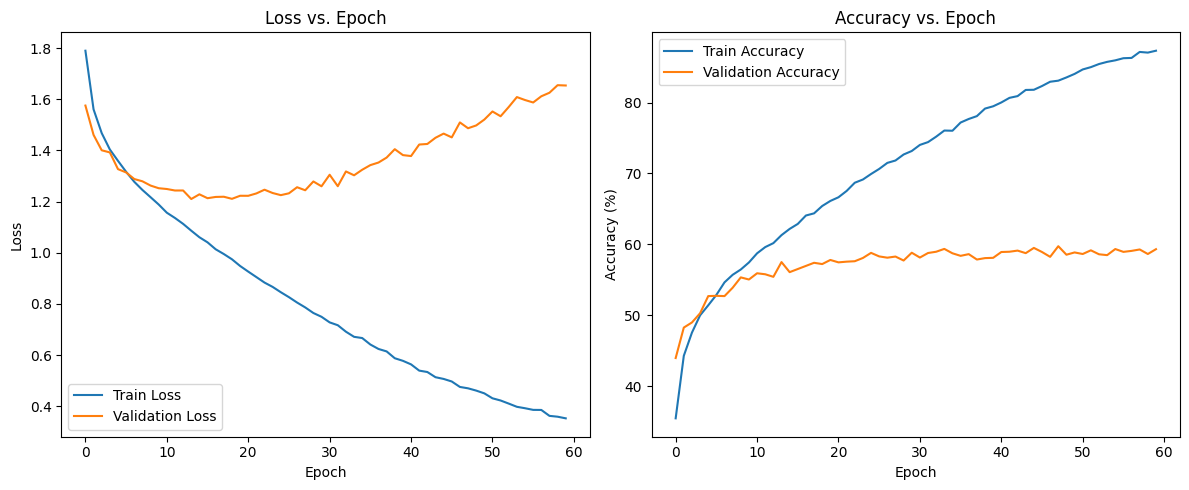

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [ ]:
# YOUR CODE HERE
test_loss, test_acc = eval_epoch(model, criterion, testloader, test_mode=True)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.6262, Test Accuracy: 60.06%


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [2]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # YOUR CODE HERE
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3072),
            nn.BatchNorm1d(3072),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(3072, 3072),
            nn.BatchNorm1d(3072),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(3072, 2560),
            nn.BatchNorm1d(2560),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(2560, num_classes)

    def forward(self, x):
        # YOUR CODE HERE
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.layers(x)
        x = self.linear(x)
        return x


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

The CNN model significantly outperforms the FCN model, achieving a much higher test accuracy. This superior performance is achieved with a drastically lower number of trainable parameters. This efficiency stems from the CNN's architectural design.

The core advantage is parameter sharing, where a single kernel (filter) is applied across the entire image to detect a specific feature, massively reducing the parameter count compared to the FCN's dense connections. Secondly, CNNs establish a spatial hierarchy; initial layers learn simple features like edges and textures, and subsequent layers combine them to form more complex patterns and object parts. This structure also provides a degree of translation invariance, allowing the network to recognize an object regardless of its position. In contrast, the FCN loses all spatial information by treating the image as a 1D vector, which is why it performs poorly and overfits easily on image tasks.

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [ ]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]           7,168
       BatchNorm2d-2          [-1, 256, 32, 32]             512
              ReLU-3          [-1, 256, 32, 32]               0
         MaxPool2d-4          [-1, 256, 16, 16]               0
            Conv2d-5          [-1, 512, 16, 16]       1,180,160
       BatchNorm2d-6          [-1, 512, 16, 16]           1,024
              ReLU-7          [-1, 512, 16, 16]               0
         MaxPool2d-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 8, 8]       4,719,616
      BatchNorm2d-10           [-1, 1024, 8, 8]           2,048
             ReLU-11           [-1, 1024, 8, 8]               0
        MaxPool2d-12           [-1, 1024, 4, 4]               0
          Flatten-13                [-1, 16384]               0
           Linear-14                  [

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
model = CNN(num_classes=10).to(device)
# YOUR CODE HERE

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [ ]:
# YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.5091; train acc: 45.23%; val loss: 1.3058; val_acc: 54.22%
(Epoch 2 / 60) train loss: 1.0208; train acc: 63.76%; val loss: 1.0088; val_acc: 64.18%
(Epoch 3 / 60) train loss: 0.8113; train acc: 71.64%; val loss: 0.7583; val_acc: 73.86%
(Epoch 4 / 60) train loss: 0.6735; train acc: 76.66%; val loss: 0.8378; val_acc: 72.24%
(Epoch 5 / 60) train loss: 0.5747; train acc: 80.15%; val loss: 0.7536; val_acc: 74.60%
(Epoch 6 / 60) train loss: 0.4906; train acc: 82.95%; val loss: 0.6518; val_acc: 78.62%
(Epoch 7 / 60) train loss: 0.4042; train acc: 85.87%; val loss: 0.7560; val_acc: 76.48%
(Epoch 8 / 60) train loss: 0.3334; train acc: 88.57%; val loss: 0.7543; val_acc: 77.30%
(Epoch 9 / 60) train loss: 0.2798; train acc: 90.23%; val loss: 0.8508; val_acc: 76.08%
(Epoch 10 / 60) train loss: 0.2370; train acc: 91.83%; val loss: 0.9667; val_acc: 74.62%
(Epoch 11 / 60) train loss: 0.1984; train acc: 93.18%; val loss: 0.7877; val_acc: 78.56%
(Epoch 12 / 60) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [ ]:
torch.save(model.state_dict(), "cnn.pth")

In [ ]:
# To load the previously saved model, simply uncomment the code below.
model.load_state_dict(torch.load('cnn.pth'))

<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

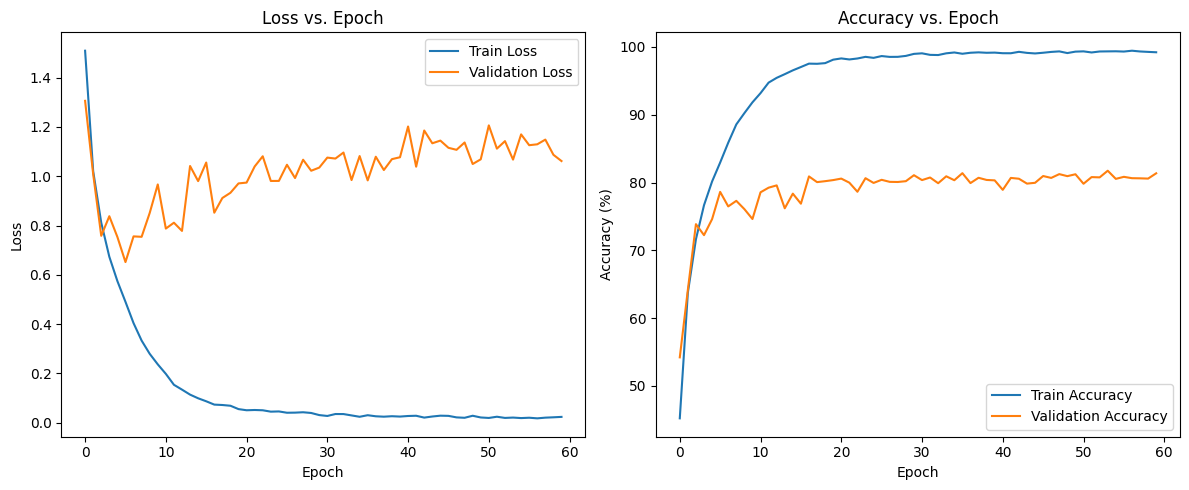

In [ ]:
# YOUR CODE HERE
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
# YOUR CODE HERE
test_loss, test_acc = eval_epoch(model, criterion, testloader, test_mode=True)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.0223, Test Accuracy: 81.69%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

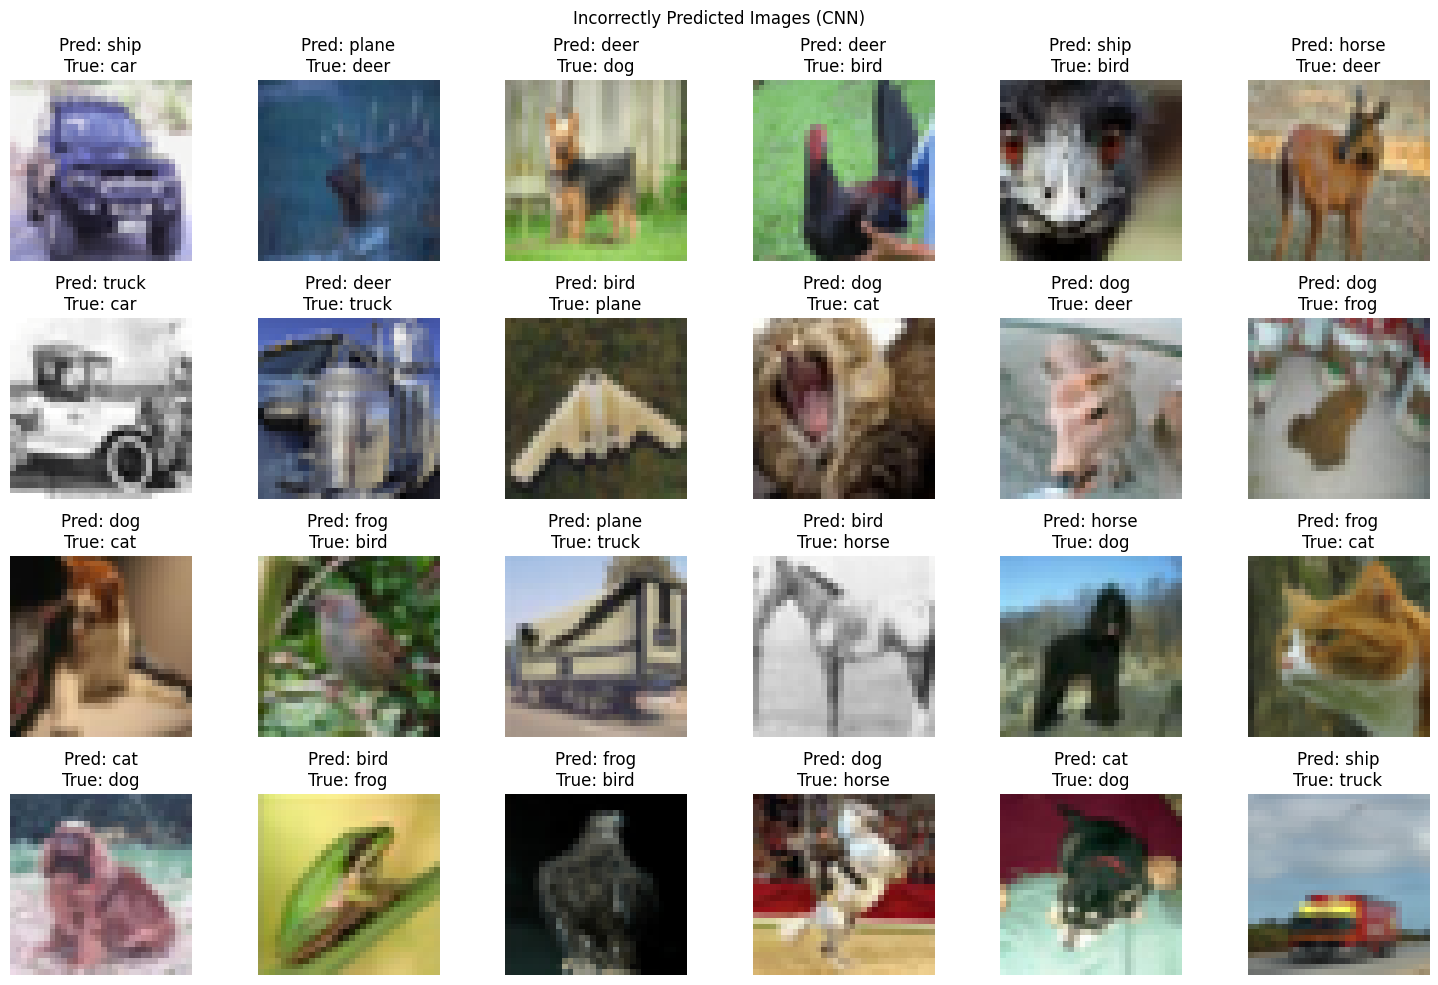

In [ ]:
# YOUR CODE HERE
model.eval()
incorrect_images = []
incorrect_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        incorrect_mask = predicted != labels
        incorrect_images.extend(inputs[incorrect_mask].cpu())
        incorrect_labels.extend(labels[incorrect_mask].cpu())
        predicted_labels.extend(predicted[incorrect_mask].cpu())
        if len(incorrect_images) >= 24:
            break

incorrect_images = incorrect_images[:24]
incorrect_labels = incorrect_labels[:24]
predicted_labels = predicted_labels[:24]

fig, axs = plt.subplots(4, 6, figsize=(15, 10))
fig.suptitle('Incorrectly Predicted Images (CNN)')
for i in range(24):
    row, col = i // 6, i % 6
    img = norminv(incorrect_images[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Pred: {classes[predicted_labels[i]]}\nTrue: {classes[incorrect_labels[i]]}')
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# YOUR CODE HERE
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        return self.features(x)

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

feature_space = []
trainloader_no_shuffle = DataLoader(trainset, batch_size=512, shuffle=False)
with torch.no_grad():
    for inputs, _ in trainloader_no_shuffle:
        inputs = inputs.to(device)
        features = feature_extractor(inputs)
        feature_space.append(features.cpu())
feature_space = torch.cat(feature_space, dim=0)  # Shape: (45000, 256)

### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

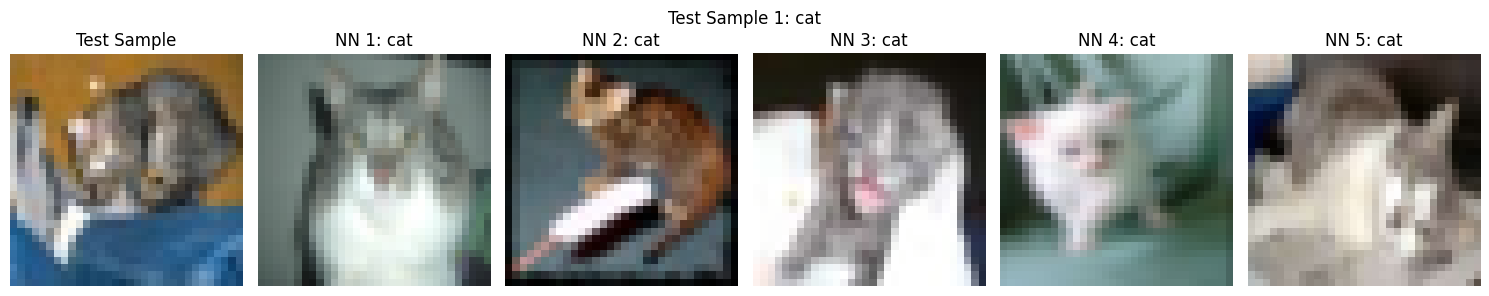

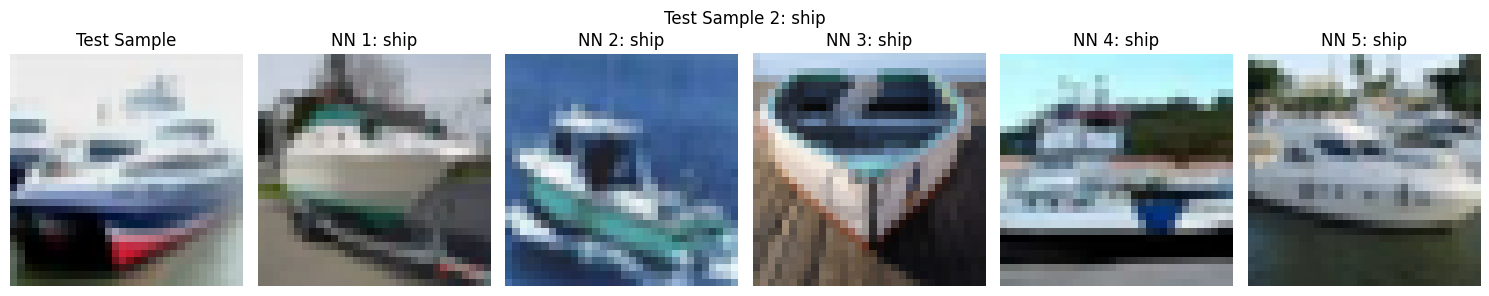

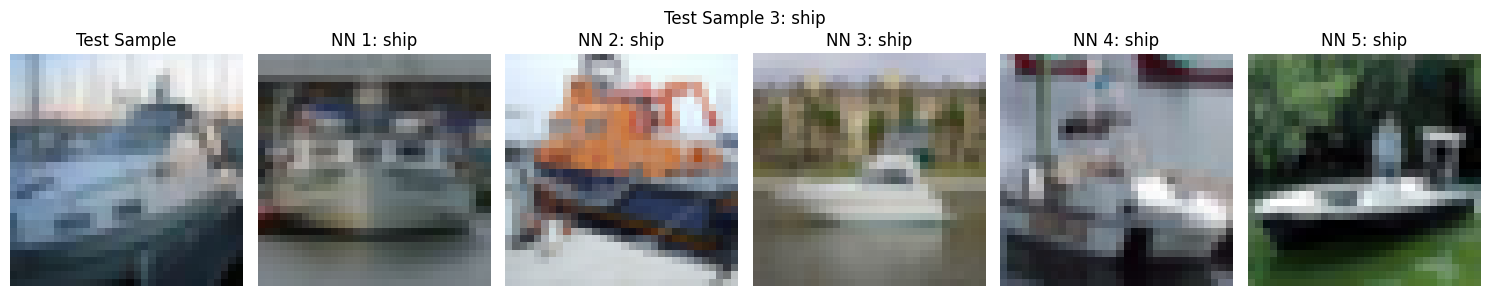

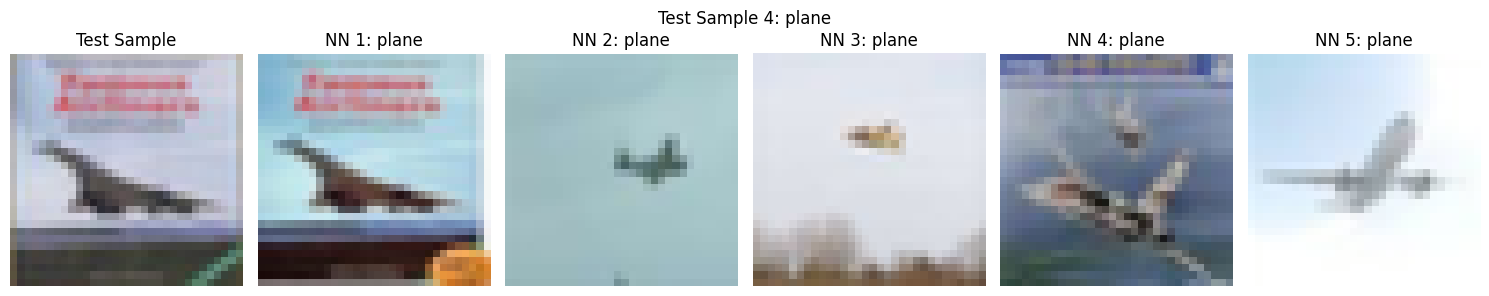

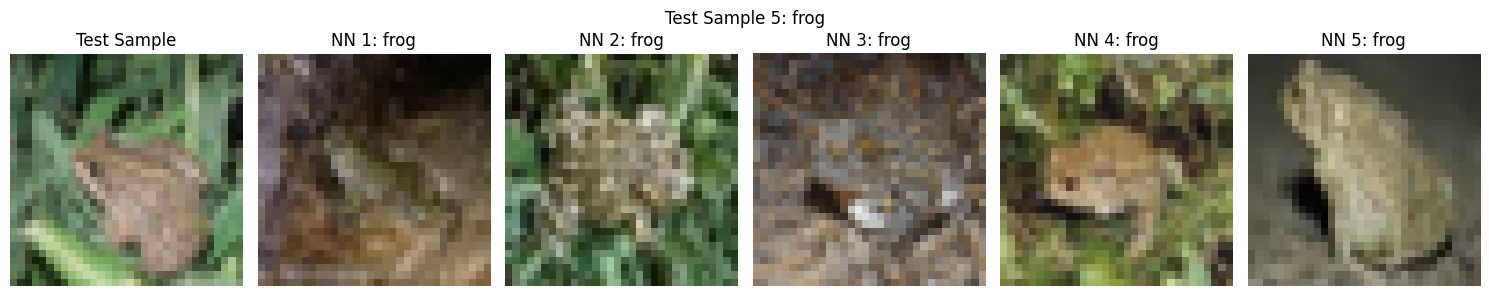

In [ ]:

# YOUR CODE HER

from sklearn.neighbors import NearestNeighbors
import numpy as np
import torch
import matplotlib.pyplot as plt


# Collect 5 correctly classified test samples
correct_samples = []
correct_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_mask = predicted == labels
        correct_samples.extend(inputs[correct_mask].cpu())
        correct_labels.extend(labels[correct_mask].cpu())
        if len(correct_samples) >= 5:
            break
correct_samples = correct_samples[:5]
correct_labels = correct_labels[:5]

# Extract features for correct samples
try:
    correct_features = feature_extractor(torch.stack(correct_samples).to(device)).detach().cpu().numpy()
except Exception as e:
    raise RuntimeError(f"Feature extraction failed: {str(e)}")

nn = NearestNeighbors(n_neighbors=5, metric='euclidean')
try:
    nn.fit(feature_space.numpy())
except Exception as e:
    raise RuntimeError(f"Failed to fit NearestNeighbors: {str(e)}")

distances, indices = nn.kneighbors(correct_features)

for i in range(5):
    fig, axs = plt.subplots(1, 6, figsize=(15, 3))
    fig.suptitle(f'Test Sample {i+1}: {classes[correct_labels[i]]}')


    img = norminv(correct_samples[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axs[0].imshow(img)
    axs[0].set_title('Test Sample')
    axs[0].axis('off')

    for j in range(5):
        nn_idx = indices[i][j]
        nn_img = norminv(trainset[nn_idx][0])
        nn_img = nn_img.permute(1, 2, 0).numpy()
        nn_img = np.clip(nn_img, 0, 1)
        axs[j+1].imshow(nn_img)
        axs[j+1].set_title(f'NN {j+1}: {classes[trainset[nn_idx][1]]}')
        axs[j+1].axis('off')

    plt.tight_layout()
    plt.show()

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [ ]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

feature_space shape: torch.Size([45000, 2560])
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Outlier index: 30510, Label: 1, Coordinates: [14.067769 79.90085 ]


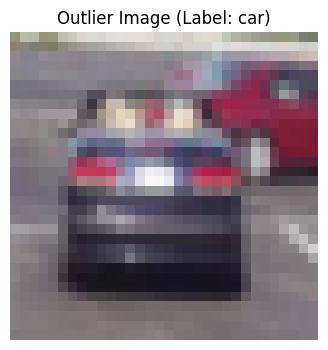

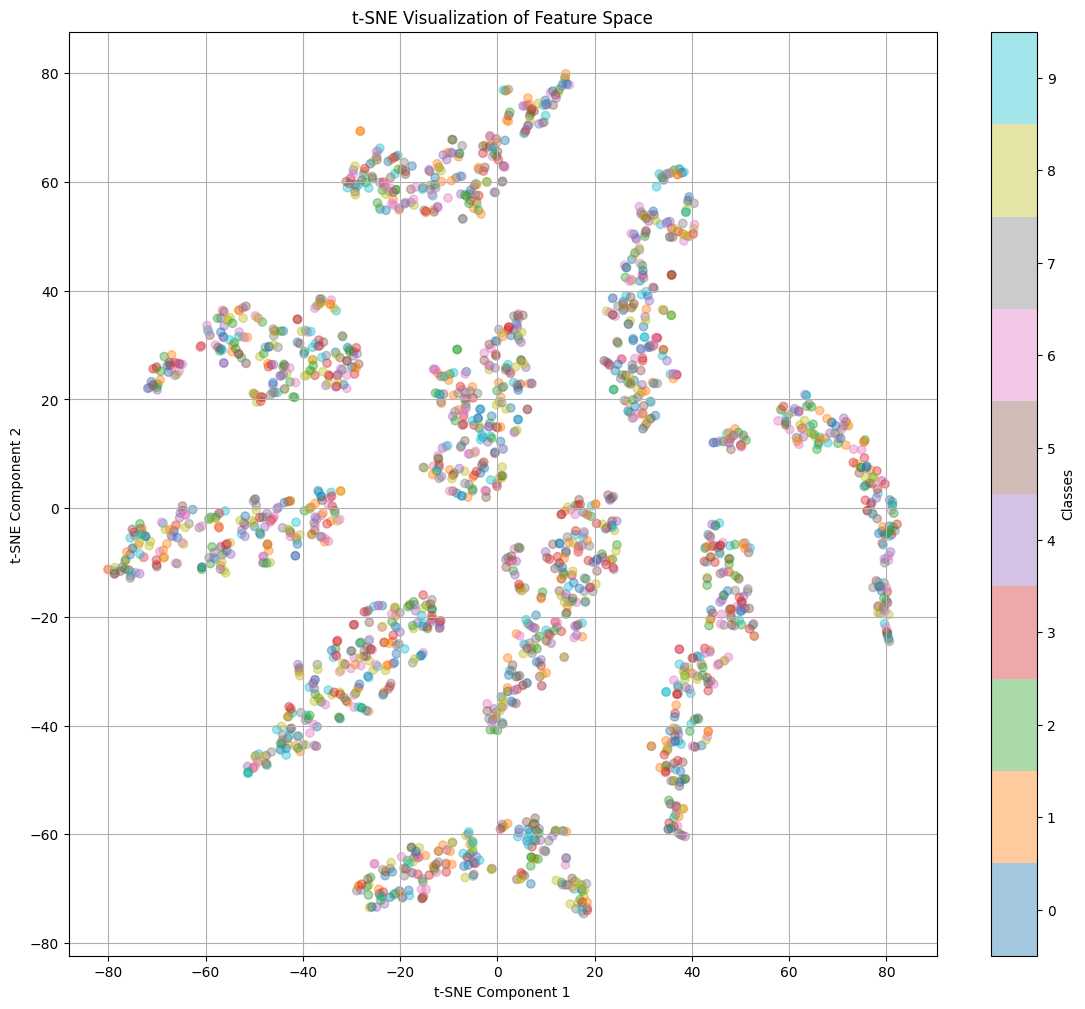

In [ ]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Verify dependencies
if 'trainset' not in globals():
    raise NameError("trainset is not defined. Ensure CIFAR-10 trainset is loaded.")
if 'feature_extractor' not in globals() or 'model' not in globals():
    raise NameError("feature_extractor or model is not defined. Ensure CNN setup is complete.")

# Recompute feature_space to ensure correctness
feature_space = []
model.eval()
feature_extractor.eval()
with torch.no_grad():
    for inputs, _ in trainloader:
        inputs = inputs.to(device)
        features = feature_extractor(inputs).detach().cpu()
        feature_space.append(features.view(features.size(0), -1))  # Flatten features
feature_space = torch.cat(feature_space, dim=0)
print(f"feature_space shape: {feature_space.shape}")  # Should be (45000, 2560)

# Sample 2000 random indices
num_samples = 2000
indices = np.random.randint(0, min(len(feature_space), len(trainset)), num_samples)

# Extract features and labels
sampled_features = feature_space[indices]
sampled_labels = np.array([trainset[idx][1] for idx in indices])
print(f"Unique labels: {np.unique(sampled_labels)}")  # Ensure all 0-9 are present
if len(np.unique(sampled_labels)) < 10:
    print("Warning: Not all classes are represented in the sample.")

# Apply t-SNE with adjusted perplexity
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)  # Lower perplexity to 10
    reduced_space = tsne.fit_transform(sampled_features.numpy())
except Exception as e:
    raise RuntimeError(f"t-SNE failed: {str(e)}")

# Find and investigate the outlier (point with max y-value)
outlier_idx = np.argmax(reduced_space[:, 1])
outlier_index = indices[outlier_idx]
print(f"Outlier index: {outlier_index}, Label: {sampled_labels[outlier_idx]}, Coordinates: {reduced_space[outlier_idx]}")

# Visualize the outlier image
outlier_image = trainset[outlier_index][0]  # Shape: (3, 32, 32)
norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))
outlier_image = norminv(outlier_image)  # Unnormalize for visualization
outlier_image = outlier_image.permute(1, 2, 0).numpy()  # Shape: (32, 32, 3)
plt.figure(figsize=(4, 4))
plt.imshow(outlier_image)
plt.title(f"Outlier Image (Label: {classes[sampled_labels[outlier_idx]]})")
plt.axis('off')
plt.show()

# Visualize t-SNE with enhanced settings
plt.figure(figsize=(14, 12))
scatter = plt.scatter(reduced_space[:, 0], reduced_space[:, 1], c=sampled_labels, cmap='tab10', alpha=0.4)
plt.colorbar(scatter, ticks=range(10), label='Classes')
plt.clim(-0.5, 9.5)
plt.title('t-SNE Visualization of Feature Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [ ]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [1]:
clipped_model = nn.Sequential(
    *list(CNNN.conv_layers.children())[0:1] 
)
clipped_model.to(device)

NameError: name 'nn' is not defined

In [ ]:
intermediate_output.shape

NameError: name 'intermediate_output' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')

NameError: name 'intermediate_output' is not defined


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
